# Example of analysis of one bacteria : YL58 (*B. coccoides*)

Here we present step by step what is done once we launch the following command line: 

```TODO THE COMMAND LINE```

#### Requirements
    - hicstuff v3.0.3 (https://github.com/koszullab/hicstuff)
    - serpentine v0.1.3 (https://github.com/koszullab/serpentine)
    - tinycov v0.3.0 (https://github.com/cmdoret/tinycov)
    - dnaglider v0.04 (https://github.com/cmdoret/dnaglider)
    - prokka 1.14.6 (https://github.com/tseemann/prokka)
    - seqkit v2.0.0 (https://bioinf.shenwei.me/seqkit/)
    - VIBRANT v1.2.1 (https://github.com/AnantharamanLab/VIBRANT)
    - Virsorter2 v2.2.3 (https://github.com/jiarong/VirSorter2)
    - pyGenomeTracks v3.6 (https://github.com/deeptools/pyGenomeTracks)
    
Depending on which part of the notebook you launch you can avoid to install some of these dependencies.

## Initialization

In [1]:
import os 

project_directory = "/data/oligomm/" # Feel free to modify your own project repository.
cpus = 16 # Change it depending on your computer.
genus = "blautia"
species = "coccoides"

# Build output directory and move into it.
os.chdir(project_directory) 
os.makedirs(f"{genus}_{species}", exist_ok=True)
os.chdir(f"{genus}_{species}")

# Defined prefix of the files base on the genus and the species.
prefix = f"{genus[0]}_{species}"

# Defined labels of the different conditions.
labels = [
    "in_vitro_R1",
    "in_vitro_R2",
    "in_vivo_2019_R1",
    "in_vivo_2019_R2",
    "in_vivo_2020_R1",
    "in_vivo_2020_R2",
]

# Defined future hicstuff folder.
hicstuff_folder = [
    "MM18",
    "MM81",
    "MM1",
    "MM11",
    "MM10",
    "MM4",
]

## Build the HiC contact map

To build the contact map we will use hicstuff (https://github.com/koszullab/hicstuff) v3.0.3. 

Fastq reads are available in SRA:  

|SRA ID|CONDITION|
|:-:|:-:|
|MM18|in vitro R1|
|MM81|in vitro R2|
|MM1|in vivo 2019 R1|
|MM11|in vivo 2019 R2|
|MM10|in vivo 2020 R1|
|MM4|in vivo 2020 R2|

The reference genome is available here...

For the following analysis to run without any issues the fastq files should be in the project directory in a fastq folder and the fasta file in fasta folder in the project directory.


In [2]:
%%script false --no-raise-error # Remove this line if you want to launch it here instead of in your terminal
%%bash

# Local variables to launch hicstuff, feel free to change them if necessary.
threads=16 
fasta=../fasta/B_coccoides.fa;

# Launch hicstuff
for i in MM18 MM81 MM1 MM11 MM10 MM4 ; 
    do \
    forward=../fastq/"$i"_R1.fastq.gz;
    reverse=../fastq/"$i"_R2.fastq.gz;
    # Run hicstuff.
    hicstuff pipeline --distance-law --duplicates --enzyme DpnII,HinfI --filter --genome $fasta \
        --outdir $i --no-clean-up --plot --threads $threads --tmpdir "$i"/tmp ; 
    done

## Contact map example of one map

In [3]:
import bacchus.io as bcio
from os.path import join

M = bcio.build_map(
    [join(hicstuff_folder[0], "abs_fragments_contacts_weighted.txt")], # Put a list of path to merged multiple replicates.
    join(hicstuff_folder[0], "fragments_list.txt"),
    bin_size=1000,
    normalize=True,
    subsample=0, # For comparison it's better to put the same numbers of contacts in all the matrices.
)

INFO :: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO :: NumExpr defaulting to 8 threads.


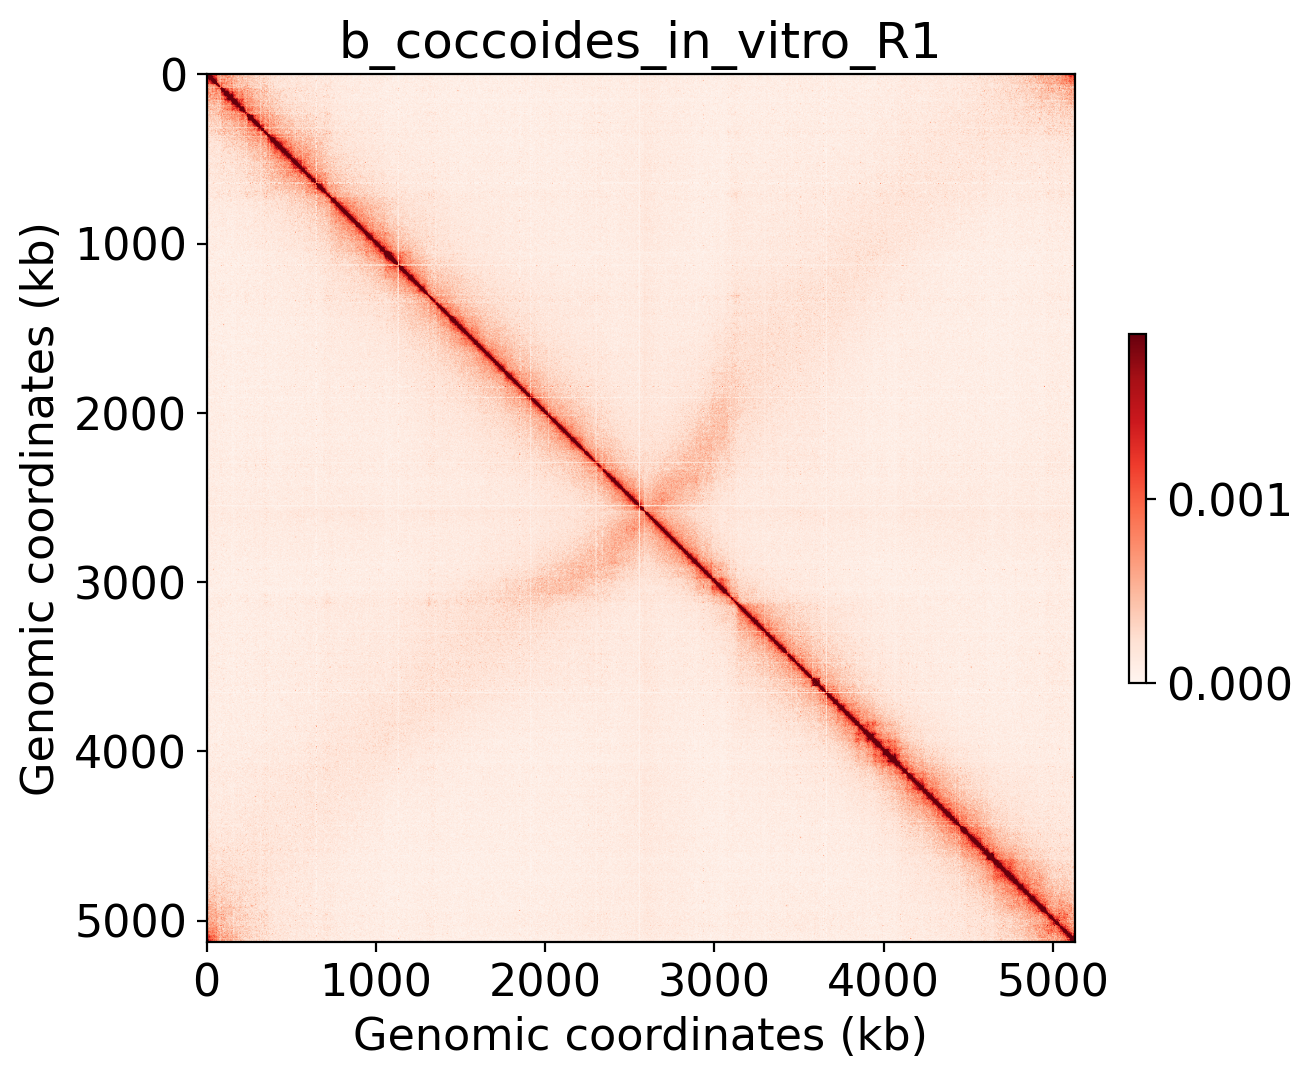

In [4]:
import bacchus.plot as bcp

os.makedirs("contact_map", exist_ok=True)

bcp.contact_map(
    M, 
    binning=1000,
    dpi=200, 
    title=prefix + "_" + labels[0],
    out_file=join("contact_map", prefix + "_" + labels[0] + ".pdf"), #Comment this line to do not save the plot.
)

## Contact map ratio between multiple matrices

In [5]:
# Import contact map using subsampling to be able to compare them and higher binnings.

M1 = bcio.build_map(
    [join(hicstuff_folder[0], "abs_fragments_contacts_weighted.txt")], # Put a list of path to merged multiple replicates.
    join(hicstuff_folder[0], "fragments_list.txt"),
    bin_size=5000, # Binning higher to be able to compare the bins without too muchj noise.
    normalize=False,
    subsample=3377167, # For comparison it's better to put the same numbers of contacts in all the matrices.
)

M2 = bcio.build_map(
    [join(hicstuff_folder[2], "abs_fragments_contacts_weighted.txt")], # Put a list of path to merged multiple replicates.
    join(hicstuff_folder[0], "fragments_list.txt"),
    bin_size=5000,
    normalize=False,
    subsample=3377167, # For comparison it's better to put the same numbers of contacts in all the matrices.
)

In [6]:
# For flexible binning we use serpentine.

import numpy as np
import serpentine as srp

# Compute auto threshold
trend, threshold = srp.MDbefore(M1, M2, show=False)

M1_serp, M2_serp, ratio_srp = srp.serpentin_binning(
        M1,
        M2,
        parallel=10, #Numbers of cpus to used.
        triangular=False,
        threshold=threshold,
        minthreshold=threshold / 5,
        iterations=20,
        verbose=False,
    )
# Do the mean to normalize serpentin ratio.
ratio_srp = ratio_srp - ratio_srp.mean()
# Compute more classical log2 ratio.
ratio_log = np.log2(M2) - np.log2(M1)

0	 Total serpentines: 1052676 (100.0 %)
0	 Total serpentines: 1052676 (100.0 %)
0	 Total serpentines: 1052676 (100.0 %)
0	 Total serpentines: 1052676 (100.0 %)
0	 Total serpentines: 1052676 (100.0 %)
0	 Total serpentines: 1052676 (100.0 %)
0	 Total serpentines: 1052676 (100.0 %)
0	 Total serpentines: 1052676 (100.0 %)
0	 Total serpentines: 1052676 (100.0 %)
0	 Total serpentines: 1052676 (100.0 %)
1	 Total serpentines: 701595 (66.6487124243357 %)
1	 Total serpentines: 701832 (66.67122647424279 %)
1	 Total serpentines: 701705 (66.6591619833643 %)
1	 Total serpentines: 701121 (66.60368432452151 %)
1	 Total serpentines: 701505 (66.64016278513047 %)
1	 Total serpentines: 702199 (66.70609000300188 %)
1	 Total serpentines: 701404 (66.63056819002239 %)
1	 Total serpentines: 701629 (66.65194228803544 %)
1	 Total serpentines: 701704 (66.65906698737314 %)
1	 Total serpentines: 702177 (66.70400009119615 %)
2	 Total serpentines: 248321 (23.589499523120125 %)
2	 Total serpentines: 248124 (23.5707853

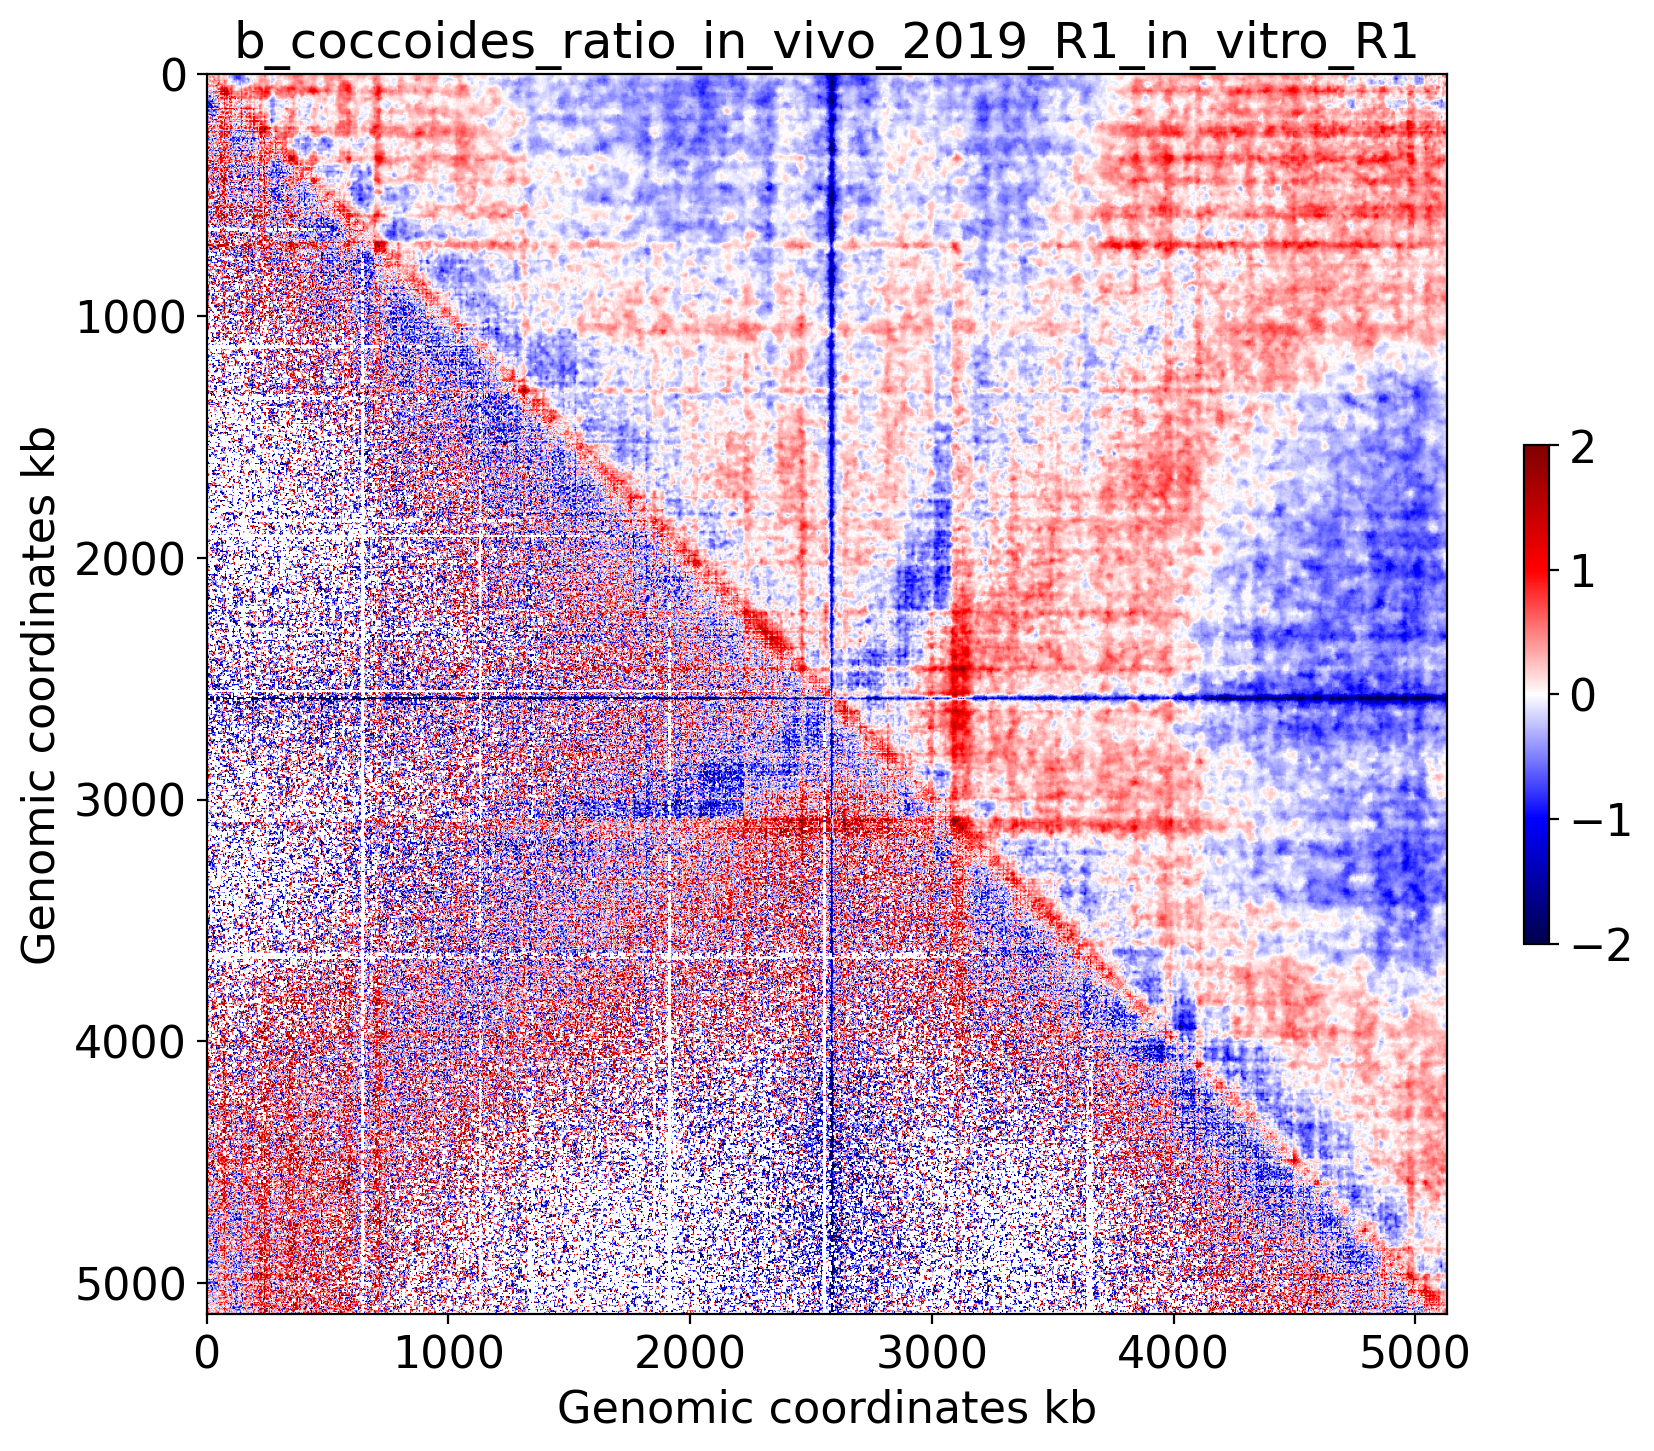

In [7]:
bcp.contact_map_ratio(
    np.tril(ratio_log, k=-1) + np.triu(ratio_srp),
    binning=5000,
    dpi=200,
    ratio = True,
    title=prefix + "_ratio_" + labels[2] + "_" + labels[0],
    out_file=join("contact_map", prefix + "_ratio_" + labels[2] + "_" + labels[0] + ".pdf"), #Comment this line to do not save the plot.
)

## Distance law

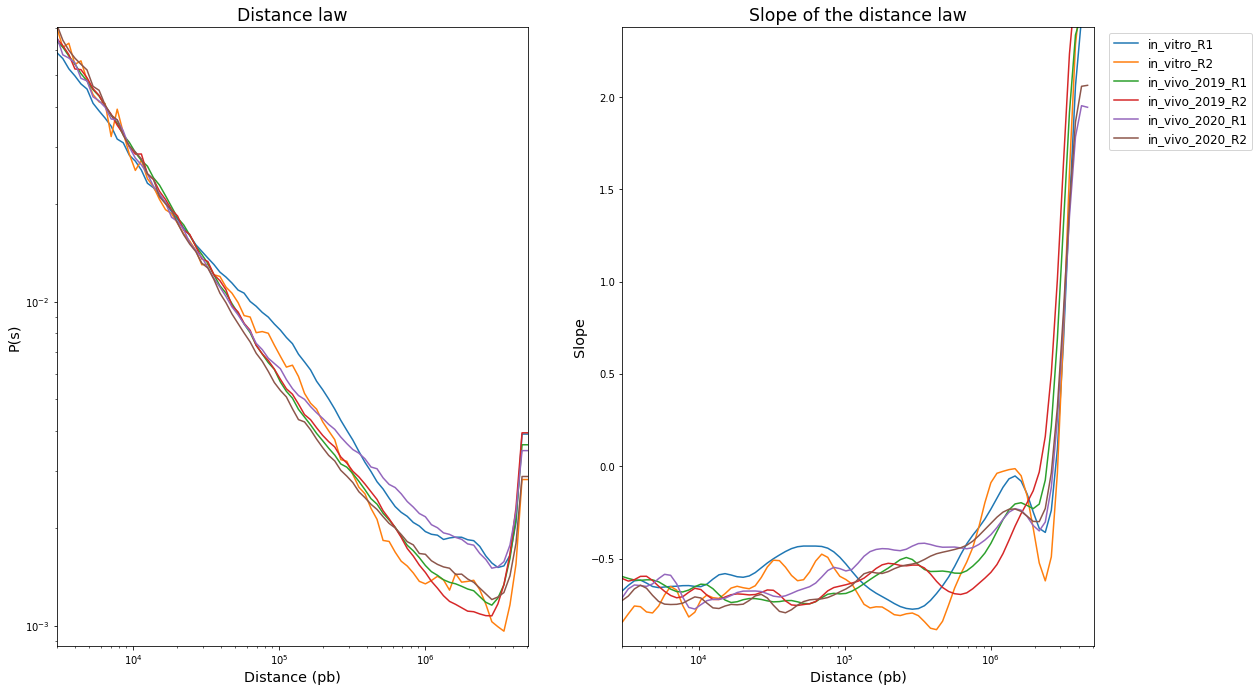

In [8]:
import  hicstuff.distance_law as hcdl

# Defined output:
output_file_img = "distance_law.pdf"
output_file_table = "distance_law.txt"

# Defined distance law files.
distance_law_files = []
for folder in hicstuff_folder:
    distance_law_files.append(
        join(folder, "distance_law.txt")
    )

# Make new lists for the modified distance law.
length_files = len(distance_law_files)
xs = [None] * length_files
ps = [None] * length_files
names = [None] * length_files
for i in range(length_files):
    xs[i], ps[i], names[i] = hcdl.import_distance_law(distance_law_files[i])
names = [name[0] for name in names]
inf = 3000
sup = max(max(xs[0], key=len))
# Iterate on the different file given by the user.
for i in range(length_files):
    # Make the average
    xs[i], ps[i] = hcdl.average_distance_law(xs[i], ps[i], sup, False)
# Normalize and make the derivative
ps = hcdl.normalize_distance_law(xs, ps, inf, sup)
hcdl.plot_ps_slope(xs, ps, labels, output_file_img, inf, sup)
hcdl.export_distance_law(xs, ps, labels, output_file_table)

## HiCreppy

In [9]:
# Compute HiCreppy matrices
import bacchus.hic as bch
import hicstuff as hio

binning = 10_000 #Large binning for HiCreppy.

# Files names
matrice_files = []
fragment_file = join(hicstuff_folder[0], "fragments_list.txt")
for folder in hicstuff_folder:
    matrice_files.append(
        join(folder, "abs_fragments_contacts_weighted.txt")
    )

# Save the matrices as cool format:
os.makedirs("cool", exist_ok=True)
cool_files = []

# Import matrix as 
for i, matrix_file in enumerate(matrice_files):
    cool_out = join("cool", f"{labels[i]}_{binning // 1000}kb.cool")
    # Create cool file if doesn't exist.
    if not os.path.isfile(cool_out):
        M, frags = binned_map(matrix_file, fragment_file, 10000)
        matrix.append(M.tocoo())
        hio.save_cool(
            cool_out,
            M,
            frags,
            metadata={"hicstuff": "3.1.0", "bin-type": "fixed"},
        )
    cool_files.append(cool_out)
    
corr_matrix = bch.get_hicreppy(cool_files, subsample=0, h=None)

Found SCC of 0.176 with h=0.
Found SCC of 0.457 with h=1.
Found SCC of 0.623 with h=2.
Found SCC of 0.724 with h=3.
Found SCC of 0.785 with h=4.
Found SCC of 0.823 with h=5.
Found SCC of 0.849 with h=6.
Found SCC of 0.879 with h=7.
Found SCC of 0.888 with h=8.
Found SCC of 0.192 with h=0.
Found SCC of 0.448 with h=1.
Found SCC of 0.577 with h=2.
Found SCC of 0.667 with h=3.
Found SCC of 0.725 with h=4.
Found SCC of 0.775 with h=5.
Found SCC of 0.812 with h=6.
Found SCC of 0.833 with h=7.
Found SCC of 0.857 with h=8.
Found SCC of 0.874 with h=9.
Found SCC of 0.167 with h=0.
Found SCC of 0.447 with h=1.
Found SCC of 0.603 with h=2.
Found SCC of 0.704 with h=3.
Found SCC of 0.769 with h=4.
Found SCC of 0.807 with h=5.
Found SCC of 0.85 with h=6.
Found SCC of 0.865 with h=7.
Found SCC of 0.885 with h=8.
Found SCC of 0.901 with h=9.
Found SCC of 0.134 with h=0.
Found SCC of 0.338 with h=1.
Found SCC of 0.43 with h=2.
Found SCC of 0.507 with h=3.
Found SCC of 0.576 with h=4.
Found SCC of 0.6

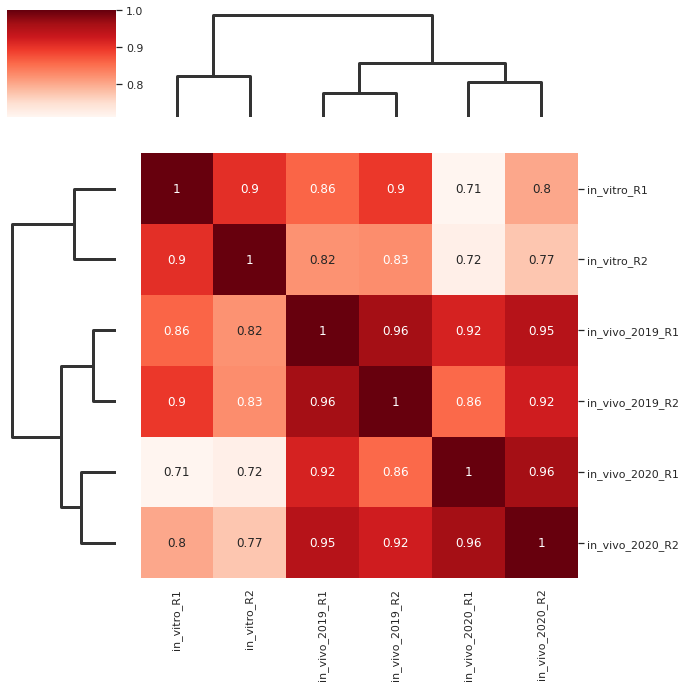

In [10]:
# Plot the hicreepy correlation matrice
import bacchus.plot as bcp

out_file = "hicreppy.pdf"
bcp.hicreppy_plot(corr_matrix, labels, out_file)

## Build coverage plot

To build the plot we use covplot function from tinycov.

In [11]:
#%%script false --no-raise-error # Remove this line to launch it.
import matplotlib.pyplot as plt
from os.path import join
from tinycov.tinycov import covplot

# Defined forward bam files for computing the coverage.
bam_files = []
for folder in hicstuff_folder:
    # If sorted bam exists take it instead of usual bam
    if os.path.isfile(join(folder, "tmp", "for.sorted.bam")):
        bam_files.append(join(folder, "tmp", "for.sorted.bam"))
    else:
        bam_files.append(join(folder, "tmp", "for.bam"))

# Create a coverage directory and save positions of the cov files.
os.makedirs("cov", exist_ok=True)
cov_files = []
for i, bam_file in enumerate(bam_files):
    # Defined names of the files and  title according to the label.
    label = labels[i]
    output_fig = join("cov", prefix + "_" + label + "_cov.pdf")
    output_file = join("cov", prefix + "_" + label + "_cov.bed")
    title = prefix + "_" + label
    # Build coverage from forward bam file.
    covplot(
        bam=bam_file,
        out=output_fig,
        res=5000,
        skip=500,
        name=title,
        text=output_file,
        circular=True,
    )
    plt.close()
    cov_files.append(output_file)

basepair:  63%|██████▎   | 3237065/5128583 [00:09<00:06, 302581.66it/s]


basepair:   9%|▊         | 439124/5128583 [00:00<00:06, 733992.04it/s]


basepair:  56%|█████▌    | 2875868/5128583 [00:02<00:02, 1081609.33it/s]


basepair:  25%|██▍       | 1263425/5128583 [00:01<00:04, 819960.91it/s]


chromosome: 100%|██████████| 1/1 [00:06<00:00,  6.85s/it]


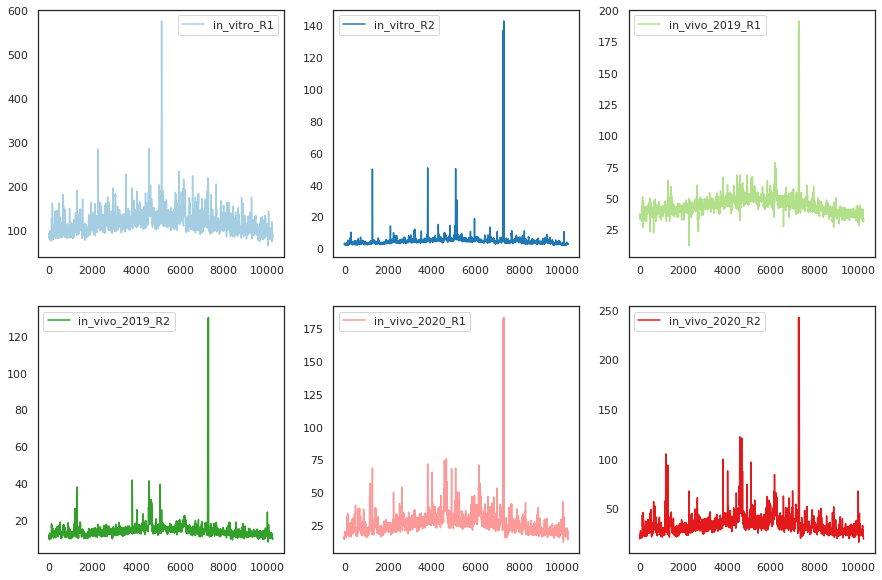

In [12]:
# Display coverage plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Plot cov for all conditions
color = sns.color_palette("Paired")
fig, ax = plt.subplots(2,3, figsize=(15, 10))
for k, file in enumerate(cov_files):
    i = k // 3
    j = k % 3
    cov_data = np.array(pd.read_csv(
            file, sep="\t", header=None, names=["chr", "start", "end", "val"]
        ).val)
    ax[i, j].plot(cov_data, label=labels[k], alpha=1, color=color[k])
    ax[i, j].legend()

## Annotation

First the script will compute the GC content and GC skew with dnaglider and detect parS sites with parS finder scirpt.

Then it will performed genoma annotation. In our analysis, we used the NCBI Prokaryotic Annotation Pipeline (PGAP), in this example we used prokka as it it's easier to launch and much faster. However, the annotation might less "good".

The script here will also launch VIBRANT and Virsorter2 for prophage annotation. If you wnat more information about the used parameters you can look at the commands in the 'oligomm_analysis/scripts/genome_annotation.sh' script.

In [13]:
%%script false --no-raise-error # Remove this line if you want to launch it here instead of in your terminal
import subprocess

# Defined fasta file.
fasta = "../fasta/B_coccoides.fa"

# Defined path of genmoe_annotation.sh. It should be in the github repository of this analysis.
script_path = "/home/rsg/repo/oligomm_analysis/scripts/genome_annotation.sh"
# Launch genome annotation script.
cmd_annotation = f"{script_path} {genus} {species} {prefix} {fasta} {cpus}"
annotation_process = subprocess.Popen(cmd_annotation, shell=True)
out, err = annotation_process.communicate()

## Ori ter detection and ratio ori-ter

In [14]:
import bacchus.io as bcio
import bacchus.oriter as bco
import pandas as pd
from os.path import join

# Defined files
oriter_file = join("annotation", prefix + "_oriter.bed")
ratio_file = join("cov", "ratio_ori_ter.txt")
gc_skew_file = join("annotation", prefix + "_gcskew.bed")
pars_file = join("annotation", prefix + "_pars.bed")

# Extract data:
gc_skew_data = pd.read_csv(
    gc_skew_file, sep="\t", header=0, names=["chr", "start", "end", "val"]
)
pars_data = pd.read_csv(
    pars_file,
    sep="\t",
    header=None,
    names=["chr", "start", "end", "type", "seq", "err"],
)

# Detect ori and ter and save it in a file.
ori, ter = bco.detect_ori_ter(
            gc_skew_data,
            pars_data,
        )
with open(oriter_file, "w") as out:
    chrom = genus[0].upper() + "_" + species
    out.write("%s\t%s\t%s\t%s\n" % (chrom, ori - 1, ori + 1, "ori"))
    out.write("%s\t%s\t%s\t%s\n" % (chrom, ter - 1, ter + 1, "ter"))


# Compute the ori/ter coverage ratio.
with open(ratio_file, "w") as out:
    for i, cov_file in enumerate(cov_files):
        label = labels[i]
        cov_data = pd.read_csv(
            cov_file, sep="\t", header=None, names=["chr", "start", "end", "val"]
        )
        ratio, ori_cov, ter_cov = bco.compute_oriter_ratio(
            cov_data, ori, ter
        )
        out.write("%s\t%s\t%s\t%s\n" % (label, ori, ter, ratio))
        print(f"{label}\t{ori/1000}kb\t{ter/1000}kb\t{round(ratio, 4)}\n")

in_vitro_R1	2564.5kb	4890.5kb	1.3402

in_vitro_R2	2564.5kb	4890.5kb	1.9928

in_vivo_2019_R1	2564.5kb	4890.5kb	1.3953

in_vivo_2019_R2	2564.5kb	4890.5kb	1.294

in_vivo_2020_R1	2564.5kb	4890.5kb	1.4378

in_vivo_2020_R2	2564.5kb	4890.5kb	1.3537



## Display pyGenometracks plot

In [15]:
import bacchus.hic as bch
import bacchus.io as bcio
import cooler
import hicstuff.hicstuff as hcs
import hicstuff.io as hio
import numpy as np
import os
import pandas as pd
import subprocess
from os.path import join

# Defined matrix you want to display (id of the label).
k = 0 # Change this value to change the condition displayed.
bin_size = 1000
label = labels[k]

# Defined matrices files:
matrice_files = []
fragment_file = join(hicstuff_folder[0], "fragments_list.txt")
for folder in hicstuff_folder:
    matrice_files.append(
        join(folder, "abs_fragments_contacts_weighted.txt")
    )
        
# Transform matrix in cool file to be displayed by pyGenomeTracks
cool_out = join(
    "cool", "{0}_{1}kb.cool".format(label, bin_size // 1000)
)
if not os.path.isfile(cool_out):
    M, frags = bcio.binned_map(matrice_files[k], fragment_file, bin_size)
    os.makedirs("cool", exist_ok=True)
    hio.save_cool(
        cool_out,
        M,
        frags,
        metadata={"hicstuff": "3.1.0", "bin-type": "fixed"},
    )
cool_matrix = cooler.Cooler(cool_out)
cooler.balance.balance_cooler(cool_matrix, mad_max=50, min_nnz=0, store=True)

# Look for the cmap
M = hcs.normalize_sparse(M, norm="ICE", n_mad=10)
M = bch.get_symmetric(M)
M = M.toarray()
max_cmap = np.percentile(M, 99)

# Extract max and min coverage for the plot.
cov_data = np.array(pd.read_csv(
            cov_files[k], sep="\t", header=None, names=["chr", "start", "end", "val"]
        ).val)
max_cov = np.percentile(cov_data, 99)
min_cov = np.percentile(cov_data, 1)

# Defined path of genmoe_annotation.sh. It should be in the github repository of this analysis.
script_path = "/home/rsg/repo/oligomm_analysis/scripts/pygenometracks.sh"

cmd_pgt = f"{script_path} {prefix} {os.path.basename(cool_out)} {max_cov} {min_cov} {max_cmap} {label}"
pgt_process = subprocess.Popen(cmd_pgt, shell=True)
out, err = pgt_process.communicate()

INFO :: variance is 595824.0508906471
INFO :: variance is 13087.544282314833
INFO :: variance is 2184.0141683730412
INFO :: variance is 533.8685311071896
INFO :: variance is 117.66285347382649
INFO :: variance is 27.842425658153772
INFO :: variance is 6.421730110338907
INFO :: variance is 1.5062453674749645
INFO :: variance is 0.3512835980340063
INFO :: variance is 0.08226211518797537
INFO :: variance is 0.019241311292191577
INFO :: variance is 0.004505323592984788
INFO :: variance is 0.0010547126773525796
INFO :: variance is 0.00024698554813438073
INFO :: variance is 5.783727792150571e-05
INFO :: variance is 1.3545262787481642e-05
INFO :: variance is 3.1723225263170528e-06


AttributeError: 'numpy.ndarray' object has no attribute 'tocoo'